# Downloading the data

In [ ]:
from google.colab import files

upload = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
import shutil

source = '/content/kaggle.json'
destination = '/root/.kaggle/kaggle.json'

os.makedirs(
    '/root/.kaggle',
    exist_ok = True
)

shutil.move(source,destination)

'/root/.kaggle/kaggle.json'

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi

api = KaggleApi()
api.authenticate()

dataset = "paultimothymooney/chest-xray-pneumonia"
destination = "/content/data"

api.dataset_download_files(
    dataset,
    destination,
    unzip = True
)

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia


# Setting data paths

In [ ]:
DATA_PATH = "/content/data/chest_xray/chest_xray"

In [ ]:
TRAIN_PATH = os.path.join(DATA_PATH,"train")
TEST_PATH = os.path.join(DATA_PATH,"test")

In [ ]:
from pathlib import Path

DATA_PATH = Path(DATA_PATH)
TRAIN_PATH = Path(TRAIN_PATH)
TEST_PATH = Path(TEST_PATH)

In [ ]:
def walk_dir(dir):
  for dir_path,dir_names,file_names in os.walk(dir):
    print(f"Path : {dir_path} --> No of directories : {len(dir_names)} No of files : {len(file_names)}")

In [ ]:
walk_dir(TRAIN_PATH)

Path : /content/data/chest_xray/chest_xray/train --> No of directories : 2 No of files : 1
Path : /content/data/chest_xray/chest_xray/train/NORMAL --> No of directories : 0 No of files : 1342
Path : /content/data/chest_xray/chest_xray/train/PNEUMONIA --> No of directories : 0 No of files : 3876


# Visualizing images

NORMAL


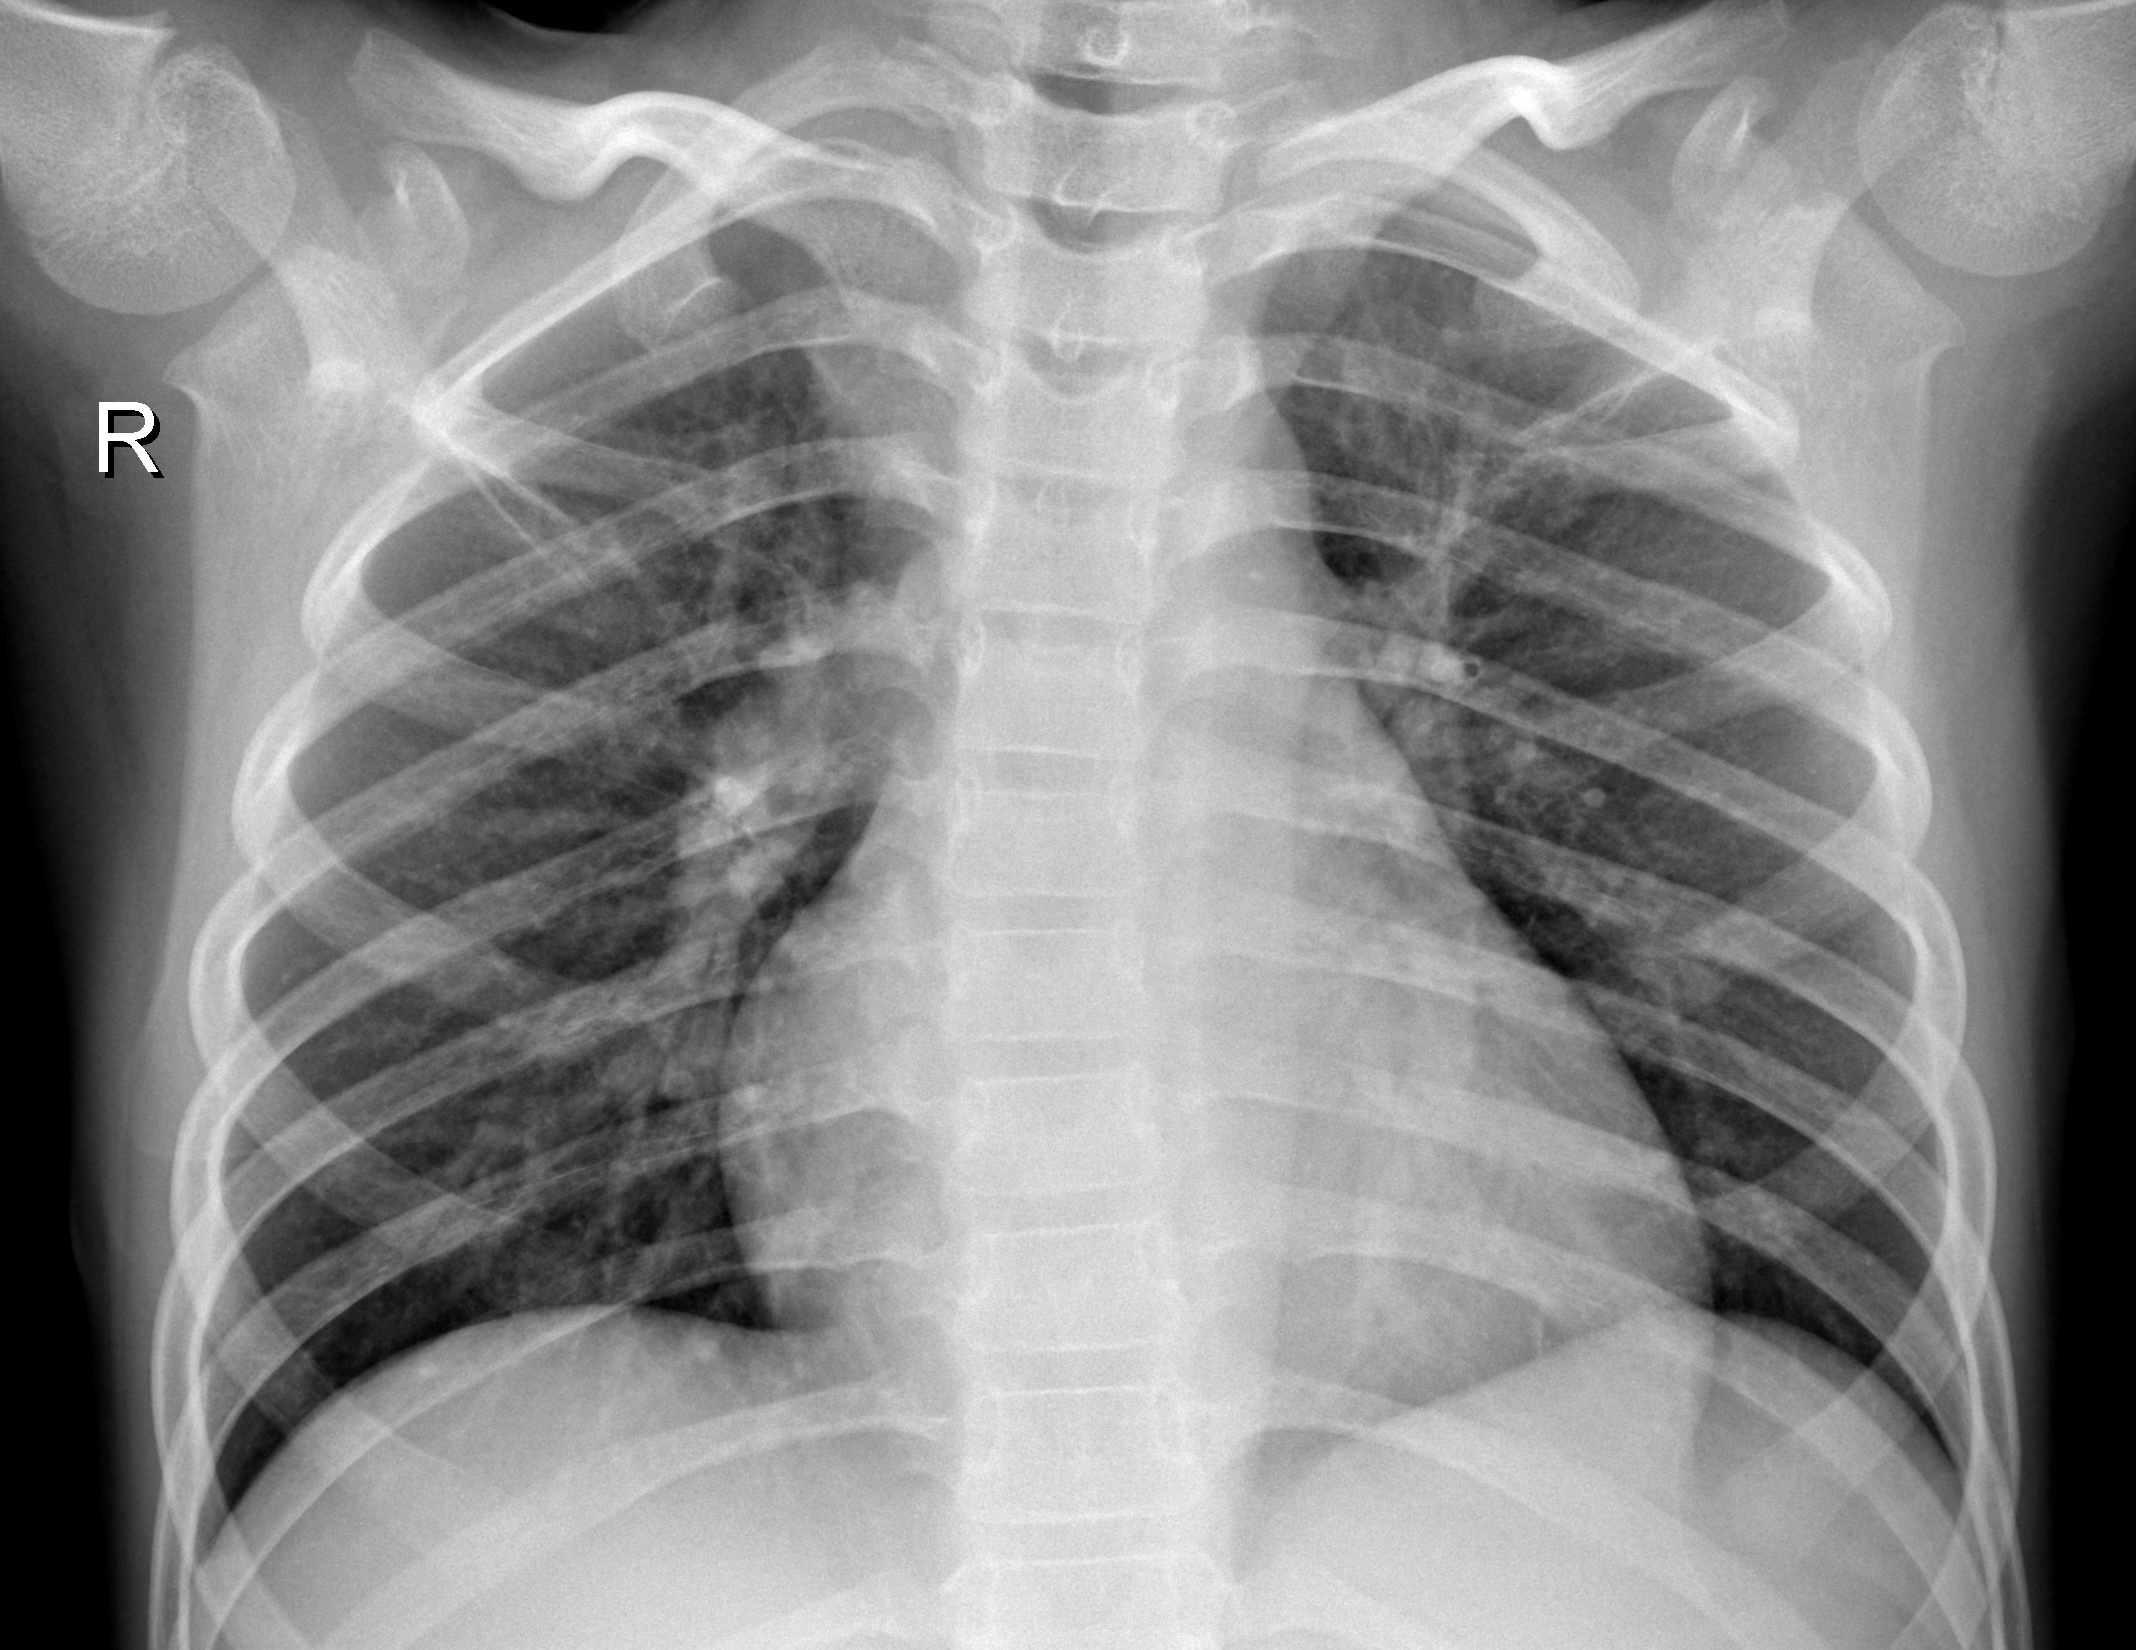

In [ ]:
import random
import pathlib
from PIL import Image

img_path = list(TRAIN_PATH.glob("*/*.jpeg"))
random_img = random.choice(img_path)
img_class = random_img.parent.stem

img = Image.open(random_img)
print(img_class)
img

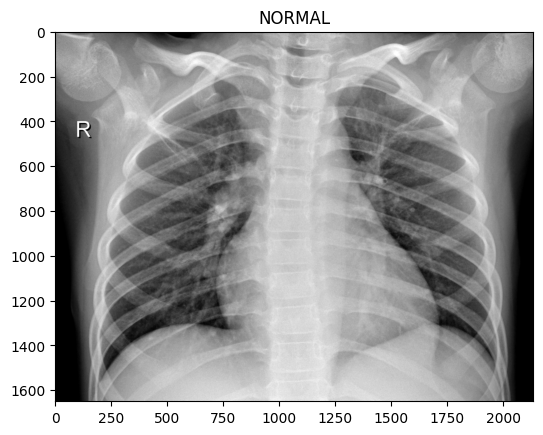

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

np_img = np.asarray(img)
plt.imshow(np_img,cmap='gray')
plt.title(img_class)
plt.show()

# Transforming the data

In [ ]:
import torch
from torchvision import transforms

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.Grayscale(),
    transforms.ToTensor()
])

In [ ]:
def plot_transformed(img_dir,transform):
  random_path = random.choice(img_dir)
  img = Image.open(random_path)
  plt.subplot(1,2,1)
  plt.imshow(img,cmap="gray")
  plt.title("Original")
  transformed_img = transform(img).permute(1,2,0)
  plt.subplot(1,2,2)
  plt.imshow(transformed_img,cmap="gray")
  plt.title("Transformed")
  plt.show()

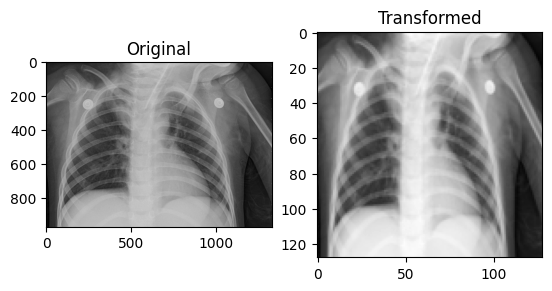

In [ ]:
plot_transformed(img_path,transform)

# Custom Dataset

In [ ]:
entries = list(os.scandir(TRAIN_PATH))
classes = [entry.name for entry in entries if entry.is_dir()]
classes

['NORMAL', 'PNEUMONIA']

In [ ]:
def get_class_names(dir):
  entries = list(os.scandir(dir))
  classes = [entry.name for entry in entries if entry.is_dir()]
  if not classes:
    raise FileNotFoundError(f"Not able to find the classes")
  class_to_idx = {cls : i for i,cls in enumerate(classes)}
  return (classes,class_to_idx)

In [ ]:
get_class_names(TRAIN_PATH)

(['NORMAL', 'PNEUMONIA'], {'NORMAL': 0, 'PNEUMONIA': 1})

In [ ]:
from torch.utils.data import Dataset

class MyDataset(Dataset):
  def __init__(self,dir,transform=None):
    self.paths = list(pathlib.Path(dir).glob('*/*.jpeg'))
    if transform:
      self.transform = transform
    self.classes, self.classes_to_idx = get_class_names(dir)

  def load_image(self,index):
    img = self.paths[index]
    return Image.open(img)

  def __len__(self):
    return len(self.paths)

  def __getitem__(self,index):
    img = self.load_image(index)
    class_name = self.paths[index].parent.name
    class_idx = self.classes_to_idx[class_name]
    if transform:
      img = transform(img)

    return (img,class_idx)



In [ ]:
train_dataset = MyDataset(TRAIN_PATH,transform)
test_dataset = MyDataset(TEST_PATH)

In [ ]:
len(train_dataset)

5216

In [ ]:
train_dataset[0][0].squeeze(0).shape

torch.Size([128, 128])

In [ ]:
def visualize_image(dataset,classes,seed=None):
  if seed:
    random.seed(seed)
  random_idx = random.randrange(len(dataset))
  img, label = dataset[random_idx]
  img_permuted = img.permute(1,2,0)
  plt.imshow(img_permuted, cmap="gray")
  plt.title(classes[label])
  plt.show()

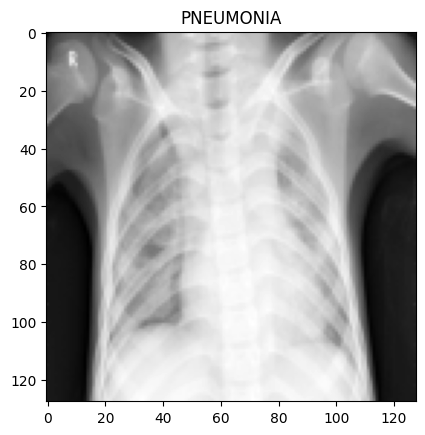

In [ ]:
visualize_image(train_dataset, classes)

# Dataloaders

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    batch_size = 32
)

test_dataloader = DataLoader(
    test_dataset,
    shuffle = False,
    batch_size = 32
)

In [ ]:
sample_data, sample_label = next(iter(train_dataloader))

In [ ]:
sample_data[0].shape, sample_label.shape

(torch.Size([1, 128, 128]), torch.Size([32]))

Text(0.5, 1.0, 'PNEUMONIA')

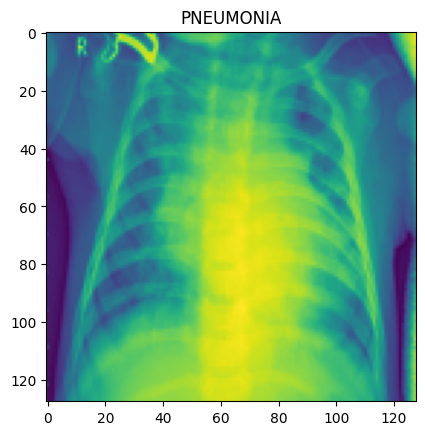

In [ ]:
plt.imshow(sample_data[0].permute(1,2,0))
plt.title(classes[sample_label[0]])

# Model building

In [ ]:
import torch
from torch import nn

In [ ]:
class Model_0(nn.Module):
  def __init__(self, input, output, hidden):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(input,
                  hidden,
                  kernel_size = 3),
        nn.ReLU(),
        nn.Conv2d(hidden,
                  hidden,
                  kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(hidden,
                  hidden,
                  kernel_size = 3),
        nn.ReLU(),
        nn.Conv2d(hidden,
                  hidden,
                  kernel_size = 3),
        nn.ReLU(),
        nn.MaxPool2d(
            kernel_size=2
        )
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(
            hidden*29*29,
            output
        )
    )

  def forward(self,x):
      x = self.conv_block_1(x)
      x = self.conv_block_2(x)
      x = self.classifier(x)
      return x

torch.manual_seed(42)
model_0 = Model_0(1,1,10).to(device)

In [ ]:
sample_data[0].unsqueeze(0).shape

torch.Size([1, 1, 128, 128])

In [ ]:
model_0.eval()
with torch.inference_mode():
  pred = model_0(sample_data.to(device))

In [ ]:
pred

tensor([[-0.0056],
        [-0.0100],
        [-0.0027],
        [-0.0046],
        [-0.0008],
        [-0.0042],
        [-0.0039],
        [-0.0048],
        [-0.0063],
        [-0.0012],
        [-0.0032],
        [-0.0068],
        [-0.0032],
        [-0.0054],
        [-0.0044],
        [-0.0045],
        [-0.0058],
        [-0.0035],
        [-0.0034],
        [-0.0037],
        [-0.0045],
        [-0.0052],
        [-0.0033],
        [-0.0059],
        [-0.0010],
        [-0.0034],
        [-0.0047],
        [-0.0036],
        [-0.0076],
        [-0.0086],
        [-0.0037],
        [-0.0061]], device='cuda:0')

# Training the model



In [ ]:
loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.SGD(params= model_0.parameters(), lr = 0.01)

In [ ]:
def training_loop(model,dataloader,loss_fn,optimizer):
  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X,y) in enumerate(dataloader):
    X = X.to(device)
    y = y.to(device)
    y_pred = model(X)
    y = y.unsqueeze(1)
    y = y.to(torch.float)
    y_pred = torch.sigmoid(y_pred)
    loss = loss_fn(y_pred, y)
    train_loss += loss.item()
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    y_pred_label = torch.round(y_pred)
    train_acc += (y_pred_label == y).sum().item() / len(y_pred)
  train_loss /= len(dataloader)
  train_acc /= len(dataloader)
  return train_loss, train_acc

In [ ]:
def test_loop(model,dataloader,loss_fn,optimizer):
  model.eval()
  test_loss, test_acc = 0 ,0
  with torch.inference_mode():
    for batch, (X,y) in enumerate(dataloader):
      X = X.to(device)
      y = y.to(device)
      y_pred = model(X)
      y = y.unsqueeze(1)
      y = y.to(torch.float)
      y_pred = torch.sigmoid(y_pred)
      loss = loss_fn(y_pred, y)
      test_loss += loss.item()
      y_pred_label = torch.round(y_pred)
      test_acc +=  (y_pred_label == y).sum().item() / len(y_pred)
    test_loss /= len(dataloader)
    test_acc /= len(dataloader)
    return test_loss, test_acc


In [ ]:
from tqdm.auto import tqdm
def train(model, train_data, test_data, loss_fn, optim, epochs):
  result = {
      "train_loss": [],
      "train_acc": [],
      "test_loss": [],
      "test_acc": []
  }
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = training_loop(
        model,
        train_data,
        loss_fn,
        optim
    )
    test_loss, test_acc = test_loop(
        model,
        test_data,
        loss_fn,
        optim
    )
    print(
        f"train loss: {train_loss} test loss :{test_loss} train_acc : {train_acc} test_acc : {test_acc}"
    )
    result["train_loss"].append(train_loss)
    result["train_acc"].append(train_acc)
    result["test_loss"].append(test_loss)
    result["test_acc"].append(test_acc)

  return result

In [ ]:
# To reset the weights
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform(m.weight.data)

In [ ]:
model_0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 0.2560,  0.2778, -0.0770],
                        [ 0.3072, -0.0721,  0.0681],
                        [-0.1614,  0.1964,  0.2945]]],
              
              
                      [[[-0.2411,  0.2930,  0.0654],
                        [ 0.2491,  0.0479,  0.1634],
                        [-0.0446,  0.2594,  0.0519]]],
              
              
                      [[[-0.1552,  0.0854, -0.1531],
                        [-0.0387, -0.1350,  0.2216],
                        [-0.2628, -0.1533, -0.0937]]],
              
              
                      [[[-0.1977,  0.0341, -0.3265],
                        [ 0.3034, -0.2808,  0.2599],
                        [ 0.0579, -0.1056,  0.2088]]],
              
              
                      [[[ 0.0562,  0.2735,  0.0407],
                        [-0.1007,  0.0940, -0.0859],
                        [ 0.1447,  0.3020,  0.1972]]],
              
              
      

In [ ]:
results = train(
    model_0,
    train_dataloader,
    test_dataloader,
    loss_fn,
    optimizer,
    20
)

  0%|          | 0/50 [00:00<?, ?it/s]

train loss: 0.4972361997226996 test loss :0.425751781463623 train_acc : 0.7659125766871165 test_acc : 0.834375
train loss: 0.24730754844798633 test loss :0.4287159763276577 train_acc : 0.9050996932515337 test_acc : 0.80625
train loss: 0.18300413203202873 test loss :0.698615958634764 train_acc : 0.9288726993865031 test_acc : 0.759375
train loss: 0.15995836660174503 test loss :0.9235879180487245 train_acc : 0.937691717791411 test_acc : 0.7046875
train loss: 0.15510016742613783 test loss :0.5386873949319124 train_acc : 0.9409509202453987 test_acc : 0.7921875
train loss: 0.13887661288669503 test loss :0.5745916409417987 train_acc : 0.9438266871165644 test_acc : 0.8
train loss: 0.13843793692810039 test loss :0.7739337690174579 train_acc : 0.9480444785276073 test_acc : 0.78125
train loss: 0.12960016125230336 test loss :0.9692630298202858 train_acc : 0.9491947852760736 test_acc : 0.73125
train loss: 0.13216811202557907 test loss :0.9945273380028083 train_acc : 0.9516871165644172 test_acc : 0.

In [ ]:
torch.save(model_0.state_dict(), "model.pth")

# Plotting the predictions

In [ ]:
def get_random_image(dataset):
  random_idx = random.randrange(len(dataset))
  img, label = dataset[random_idx]
  return img, label

In [ ]:
img, label = get_random_image(test_dataset)

In [ ]:
def visualize_tensor(img,label):
  np_img = img.permute(1,2,0).numpy()
  plt.imshow(np_img,cmap="gray")
  plt.title(classes[label])

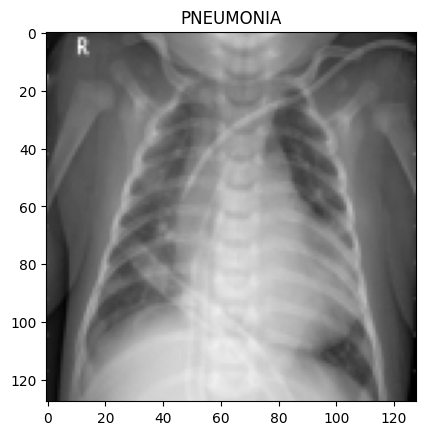

In [ ]:
visualize_tensor(img,label)

In [ ]:
def get_predictions_for_single(model,img):
  img = img.to(device)
  img = img.unsqueeze(1)
  model.eval()
  with torch.inference_mode():
    logits = model(img)
    pred = torch.sigmoid(logits)
  return pred

In [ ]:
get_predictions_for_single(model_0, img)

tensor([[0.9996]], device='cuda:0')

In [ ]:
def get_predictions_for_batch(model,batch):
  img, labels = batch
  img = img.to(device)
  model.eval()
  with torch.inference_mode():
    logits = model(img)
    preds = torch.sigmoid(logits)
    preds = torch.round(preds)
  return preds, labels

In [ ]:
VAL_PATH = os.path.join(DATA_PATH,"val")
val_dataset = MyDataset(VAL_PATH)

In [ ]:
val_dataloader = DataLoader(
    val_dataset,
    batch_size = 32,
    shuffle = True
)

In [ ]:
batch = next(iter(val_dataloader))

In [ ]:
get_predictions_for_batch(model_0,batch)

(tensor([[1.],
         [1.],
         [1.],
         [0.],
         [0.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.],
         [1.],
         [1.],
         [1.],
         [1.],
         [0.]], device='cuda:0'),
 tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0]))

In [ ]:
def visualize_preds(img, label):
  pred = get_predictions_for_single(model_0, img)
  pred = torch.round(pred).to(torch.int)
  plt.subplot(1,2,1)
  visualize_tensor(img, pred)
  plt.subplot(1,2,2)
  visualize_tensor(img, label)


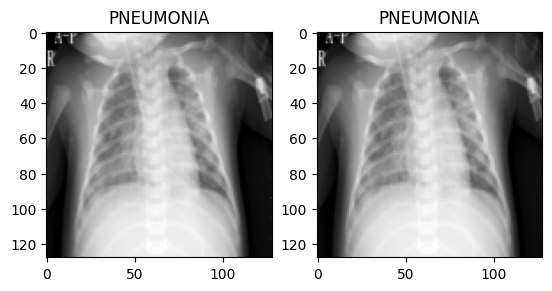

In [ ]:
visualize_preds(*get_random_image(val_dataset))

In [ ]:
test_loop(model_0,val_dataloader,loss_fn,optimizer)[1]

(0.43548867106437683, 0.8125)